   # TP53: Effects of Mutation on Interacting Proteins

<b>Standard imports for playing with and plotting data frames.</b>

In [19]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

<b>Import CPTAC data</b>

In [20]:
import CPTAC

In [21]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

### List of proteins that interact with TP53 (according to Uniprot and String)

In [22]:
gene = 'TP53'
protList = ['AXIN1', 'EP300', 'HRMT1L2', 'CARM1', 'TAF1', 'ING4', 'CABLES1', 
            'TP73', 'HIPK1', 'HIPK2', 'TP53INP1', 'TP53BP', 'WWOX', 'HCV', 'USP7', 'SYVN1', 'HSP90AB1',
           'CHD8', 'ARMC10', 'BANP', 'CDKN2AIP', 'NUAK1', 'STK11', 'LKB1', 'UHRF2', 'E4F1', 'YWHAZ',
           'MAML1', 'MKRN1', 'PML', 'MDM2', 'FBXO42', 'ATM', 'PP2R2A', 'AURKA', 'DAXX', 'BRD7', 'TRIM24',
           'L3MBTL1', 'GRK5', 'CAK', 'PTK2B', 'PYK2', 'MDM2', 'PRKCG', 'PPIF', 'KAT6A', 'UBC9', 'ZNF385B',
           'ZNF385A', 'ANKRD2', 'RFFL', 'RNF34', 'MTA1', 'COP1', 'CCAR2', 'MORC3', 'POU4F2', 'AFG1L', 'UBD',
           'TAF6', 'HPV', 'UL123', 'E1B-55K', 'BAX', 'FAS', 'BCL2', 'CREBBP', 'CDK2', 'MDM2', 'CDKN2A', 
            'CDKN1A', 'ATM', 'MDM4']

### t-test for proteome abundance of these proteins when TP53 is mutated
<b>Note: We are only interested in looking at proteins whose abundance is significantly affected by TP53 mutation, and we must do a Bonferroni correction on our p-value</b>

In [23]:
pcutoff = 0.05 / len(protList)

In [24]:
significantResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.merge_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            significantResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 

Test for CABLES1: 
Ttest_indResult(statistic=-3.929885671934063, pvalue=0.0001378458722101749)
Test for HSP90AB1: 
Ttest_indResult(statistic=4.297997992864394, pvalue=3.367565381594231e-05)
Test for CHD8: 
Ttest_indResult(statistic=4.2478330401531235, pvalue=4.10099109905482e-05)
Test for UHRF2: 
Ttest_indResult(statistic=-4.113642044468606, pvalue=6.894129428035211e-05)
Test for AURKA: 
Ttest_indResult(statistic=4.660432733263899, pvalue=1.26014474892994e-05)


### List of significantly affected proteins

In [26]:
print(significantResults)

['CABLES1', 'HSP90AB1', 'CHD8', 'UHRF2', 'AURKA']


### Build the dataframe for plotting

In [27]:
plotdf = CPTAC.merge_mutations(proteomics, gene)[['Mutation', gene]]

for protein in significantResults:
    proteindf = CPTAC.merge_mutations(proteomics, protein, gene)[[protein]]
    plotdf = plotdf.join(proteindf)

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Proteomics')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Wildtype") | (plotdf["Mutation"] == "Missense_Mutation")]
plotdf = plotdf.dropna(axis=0)

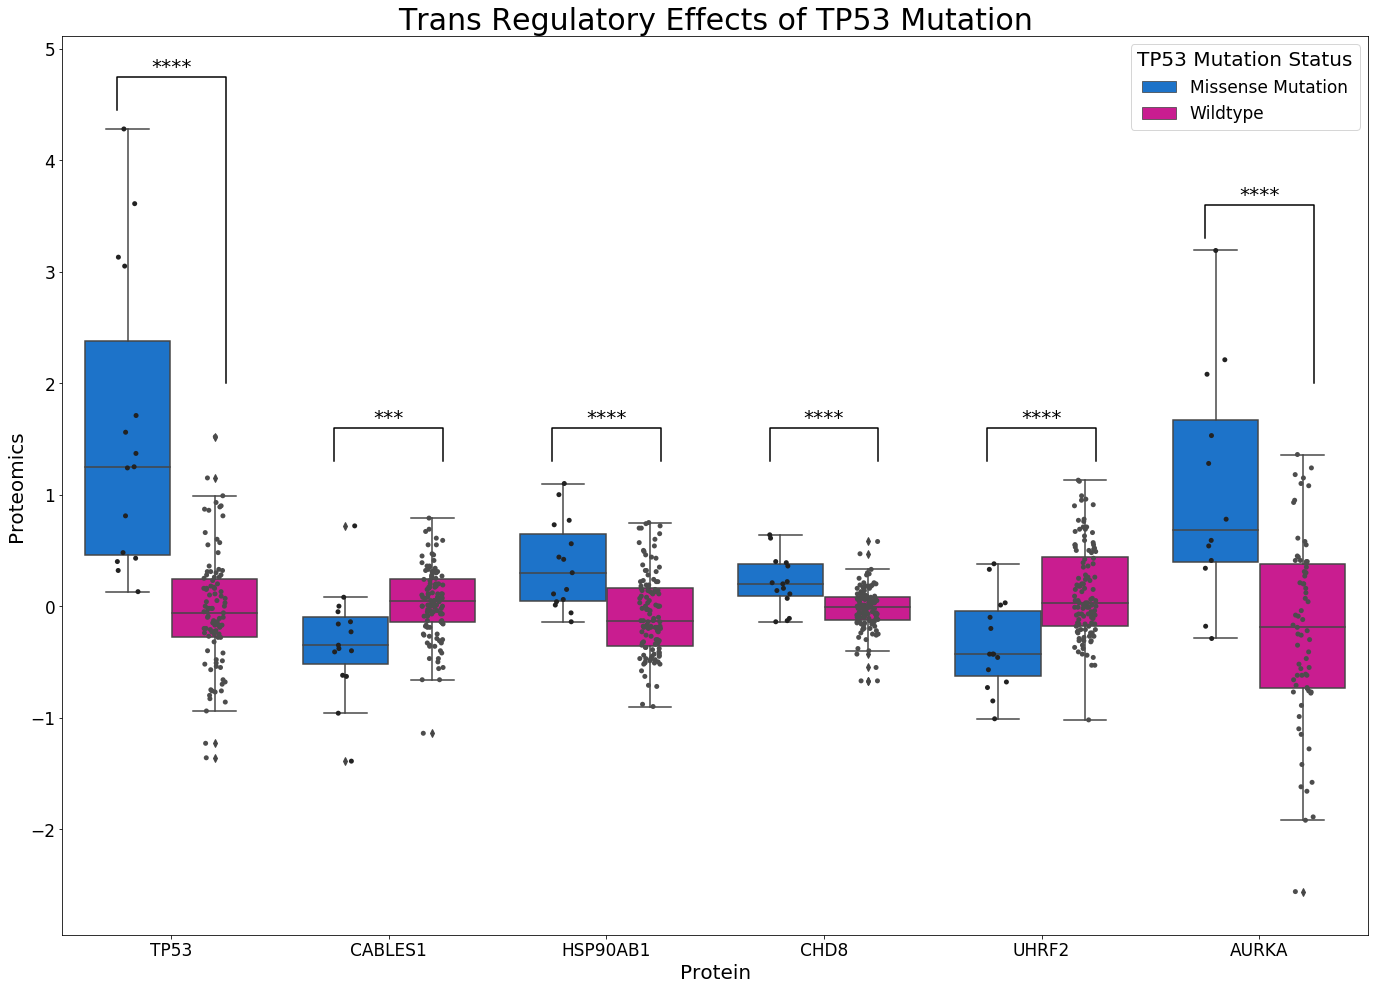

In [115]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Missense_Mutation": "#0073e6", "Wildtype": "#e60099"}

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Proteomics', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_title("Trans Regulatory Effects of TP53 Mutation", fontsize='30')
boxplt.set_xlabel('Protein', fontsize='20')
boxplt.set_ylabel('Proteomics', fontsize='20')
boxplt.tick_params(labelsize='17')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Missense Mutation', 'Wildtype'], title='TP53 Mutation Status', fontsize='17')
boxplt.get_legend().get_title().set_fontsize('20')

#Add significance indicator: TP53
x1, x2 = -0.25, 0.25
y, h, col = 4 + .45, .3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, 2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='20')

#Add significance indicator: CABLES1
x1, x2 = 0.75, 1.25
y, h, col = 1 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize='20')

#Add significance indicator: HSP90AB1
x1, x2 = 1.75, 2.25
y, h, col = 1 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='20')

#Add significance indicator: CHD8
x1, x2 = 2.75, 3.25
y, h, col = 1 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='20')

#Add significance indicator: UHRF2
x1, x2 = 3.75, 4.25
y, h, col = 1 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='20')

#Add significance indicator: AURKA
x1, x2 = 4.75, 5.25
y, h, col = 3 + .3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, 2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize='20')

plt.show()

## Phosphoproteome abundance of interacting proteins

### This is the same list as before, with some of the end numbers of the proteins removed; less specificity in protein names captures more potentially significant results in the phosphoproteomic data

In [ ]:
phosProtList = ['AXIN1', 'EP300', 'HRMT1L2', 'CARM1', 'TAF1', 'ING4', 'CABLES1', 
            'TP73', 'HIPK1', 'HIPK2', 'TP53INP1', 'TP53BP', 'WWOX', 'HCV', 'USP7', 'SYVN1', 'HSP90AB1',
           'CHD8', 'ARMC10', 'BANP', 'CDKN2AIP', 'NUAK1', 'STK11', 'LKB1', 'UHRF2', 'E4F1', 'YWHAZ',
           'MAML1', 'MKRN1', 'PML', 'MDM2', 'FBXO42', 'ATM', 'PP2R2A', 'AURKA', 'DAXX', 'BRD7', 'TRIM24',
           'L3MBTL1', 'GRK5', 'CAK', 'PTK2B', 'PYK2', 'MDM2', 'PRKCG', 'PPIF', 'KAT6A', 'UBC9', 'ZNF385B',
           'ZNF385A', 'ANKRD2', 'RFFL', 'RNF34', 'MTA1', 'COP1', 'CCAR2', 'MORC3', 'POU4F2', 'AFG1L', 'UBD',
           'TAF6', 'HPV', 'UL123', 'E1B-55K', 'BAX', 'FAS', 'BCL2', 'CREBBP', 'CDK2', 'MDM2', 'CDKN2A', 
            'CDKN1A', 'ATM', 'MDM4']

In [ ]:
significantPhosResults = [];

for protein in phosProtList:
    phosSitesdf = CPTAC.merge_mutations(phos, protein, gene)

### List of significantly affected phosphorylation sites

In [ ]:
print(sigPhosResults)